# Data 620, Project 3
July 10, 2019 
Team 6: Alice Friedman, Scott Jones, Jeff Littlejohn, and Jun Pan

## Assignment Description
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

## Text Classification: Identifying gender from the ```nltk``` names corpus  

### `nltk`  

Adapted from the site: 
https://gist.github.com/vinovator/6e5bf1e1bc61687a1e809780c30d6bf6
https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/

### Setup

First, we import the names corpus from the ```nltk``` list of corpuses, and create three sets of names. All sets will be of equal length and generated from a randomized shuffle of each of the corpuses.

- A training set, used to train the model based on our selected features

- A couple of "dev" sets, which we will use to test progress on the gender identifier and perform error analysis

- A final "test" set, which we will use to test how well our predictions ultimately worked

We will attempt XXX different versions of the 

In [1]:
import nltk
from nltk.corpus import names
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mcorpus = [(name, "male") for name in names.words("male.txt")]
fcorpus = [(name, "female") for name in names.words("female.txt")]
random.shuffle(mcorpus); random.shuffle(fcorpus)
print(mcorpus[0:5],len(mcorpus))
print(fcorpus[0:5],len(fcorpus))

corpus = mcorpus + fcorpus
random.shuffle(corpus)
print(corpus[:5], len(corpus))

[('Lionel', 'male'), ('Abdulkarim', 'male'), ('Smitty', 'male'), ('Elmore', 'male'), ('Jotham', 'male')] 2943
[('Kirstin', 'female'), ('Clementine', 'female'), ('Nanete', 'female'), ('Tootsie', 'female'), ('Isabeau', 'female')] 5001
[('Lindsy', 'female'), ('Maurise', 'male'), ('Joelle', 'female'), ('Rhona', 'female'), ('Bellamy', 'female')] 7944


There are 2,943 names classified as male, 5,001 names classified as female, and 7,944 names total.

### Function definitions to process and classify the data 

Python slices lists from the first index up to *but not including* the second given index. This is counter-intutive, but ultimately makes it easier to slice lists consecutively as '''list[:10] + lists[10:]''' will return the complete, original list.

From the textbook:  
"Each time the error analysis is repeated, we should select a *different* dev-test/training split, to ensure that the classifier does not start to reflect the idiosyncracies in the dev-test set." (pg 227)

To prevent a lot of re-coding, we can write a function to remix the development-training corpus, after setting aside the first 500 male and female names as the final test slice.

From https://www.nltk.org/book/ch06.html:  

"In naive Bayes classifiers, every feature gets a say in determining which label should be assigned to a given input value. To choose a label for an input value, the naive Bayes classifier begins by calculating the prior probability of each label, which is determined by checking frequency of each label in the training set. The contribution from each feature is then combined with this prior probability, to arrive at a likelihood estimate for each label. The label whose likelihood estimate is the highest is then assigned to the input value. 5.1 illustrates this process."

The site continues:

"Individual features make their contribution to the overall decision by "voting against" labels that don't occur with that feature very often. In particular, the likelihood score for each label is reduced by multiplying it by the probability that an input value with that label would have the feature."

In [3]:
# Create a function to return a new training and dev-test mix of the corpus for each iteration of the model
def reslicer(corpus):
    print("Reslicer returns 3 sliced, remixed set of corpora:")
    print("\tThe first returned value is the remixed training corpus, length is variable")
    print("\tThe second returned value is the remixed dev-test corpus, length is 500")
    print("\tThe third returned value is the un-remixed test set, length is 500\n")
    final_test_n = 500 # can be adjusted
    dev_test_n = 500 # can be adjusted
    
    test_corpus = corpus[:final_test_n] #reserve first 500 for the final test
    print("Test Corpus Sample: ", test_corpus[0:3], ", Length: ", len(test_corpus))
    
    dev_set = corpus[final_test_n:] #create a copy of the dev_set to preserve the original test set before shuffling
    random.shuffle(dev_set) #remix before re-slicing
    
    dev_test_corpus = dev_set[:dev_test_n]
    print("Dev-Test Corpus Sample: ",dev_test_corpus[0:3], ", Length: ", len(dev_test_corpus)) #should have length 500
    
    train_corpus = dev_set[dev_test_n:]
    print("Training Corpus Sample: ",train_corpus[0:3], ", Length: ", len(train_corpus)) #should be longer

    return train_corpus, dev_test_corpus, test_corpus


In [4]:
train_names, dev_names, test_names = reslicer(corpus)

Reslicer returns 3 sliced, remixed set of corpora:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Lindsy', 'female'), ('Maurise', 'male'), ('Joelle', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Bernadina', 'female'), ('Kinna', 'female'), ('Jammie', 'female')] , Length:  500
Training Corpus Sample:  [('Waite', 'male'), ('Staford', 'male'), ('Maddalena', 'female')] , Length:  6944


In [5]:
#re-running the code will remix the training and dev-test sets, while leaving the original test names intact
train_names, dev_names, test_names = reslicer(corpus)

Reslicer returns 3 sliced, remixed set of corpora:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Lindsy', 'female'), ('Maurise', 'male'), ('Joelle', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Mariana', 'female'), ('Northrup', 'male'), ('Anastassia', 'female')] , Length:  500
Training Corpus Sample:  [('Patience', 'female'), ('Gus', 'male'), ('Claude', 'male')] , Length:  6944


Because we will be changing the feature function each time, we can create a series of functions to process and classify the data to to minimize repeated code. 

In [6]:
# Define function to process the names through feature extractor
def feature_ext(feature_func, corpus):
    
    #first, remix and reslice the data to ensure we are using a new mix of dev-test and training data each time
    train_names, dev_names, test_names = reslicer(corpus)
    
    #then, extract features from the names slices
    train_set = [(feature_func(n), gender) for (n, gender) in train_names]
    devtest_set = [(feature_func(n), gender) for (n, gender) in dev_names]
    test_set = [(feature_func(n), gender) for (n, gender) in test_names]
    
    return train_set, devtest_set, test_set

In [28]:
def test_model(feature_func, corpus):
    feature_func = feature_func #use feature function given as arg
    corpus = corpus
    
    # Run the feature_ext function to create the necessary labeled feature sets
    train_set, devtest_set, test_set = feature_ext(feature_func, corpus)
    
    # Train the naiveBayes classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set)

    # Test the accuracy of the classifier on the dev data--this is so we can evaluate errors and make tweaks
    a = round(nltk.classify.accuracy(classifier, devtest_set), 4)*100
    accuracy = f'{a:.2f}'
    print("\n")
    print("Model is %s percent accurate" % accuracy)
    print("\n")
    
    # examine classifier to determine which last letter is most effective for predicting gender
    print(classifier.show_most_informative_features(10))
    
    #find errors    
    def find_errors(dev_names, feature_func):   
        errors = {'name' : [], 'label' : [], 'guess' : [], 'features': [] }       
        for (name, label) in dev_names:
            guess = classifier.classify(feature_func(name))
            features = feature_func(name)
            if guess != label:
                errors['name'].append(name)
                errors['label'].append(label)
                errors['guess'].append(guess)
                errors['features'].append(features)
        
        errors = pd.DataFrame(errors)
        
        #create dataframe for bar plot
        hister = pd.DataFrame(errors[['features','guess']])
        hister = pd.DataFrame(hister['features'].tolist(), index=hister.index)
        hister2 = pd.DataFrame(hister['last_letter'].value_counts())
        hister2 = hister2.sort_values('last_letter',ascending=False)
        hister2.reset_index(level=0, inplace=True)
        
        #plot bar plot of errors caused by last letter
        hister2.plot('index','last_letter', kind='bar',figsize=(20,10), fontsize=14,title="Errors: Last 3 Letters")
        
        #prints sample 
        print("\nErrors")
        print(errors.sample(20))
    
    errors = find_errors(dev_names, feature_func)
    
    return classifier

### Training on the last letter of the name

Now that we have our functions set up, we can define some different feature extraction functions and test each one.

First, we will test a model by examining only the last letter of each name. We will use ```nltk```'s built-in Naive Baysian Classifier to train the model based on this feature. 

In [29]:
def last_letter(word): #first feature function to test
    return {"last_letter": word[-1]}

Reslicer returns 3 sliced, remixed set of corpora:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Lindsy', 'female'), ('Maurise', 'male'), ('Joelle', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Jock', 'male'), ('Edouard', 'male'), ('Elspeth', 'female')] , Length:  500
Training Corpus Sample:  [('Kirsten', 'female'), ('Teodoro', 'male'), ('Dalila', 'female')] , Length:  6944


Model is 80.20 percent accurate


Most Informative Features
             last_letter = 'a'            female : male   =     39.5 : 1.0
             last_letter = 'k'              male : female =     27.7 : 1.0
             last_letter = 'f'              male : female =     15.2 : 1.0
             last_letter = 'p'              male : female =     12.5 : 1.0
             last_letter = 'v'              male : fema

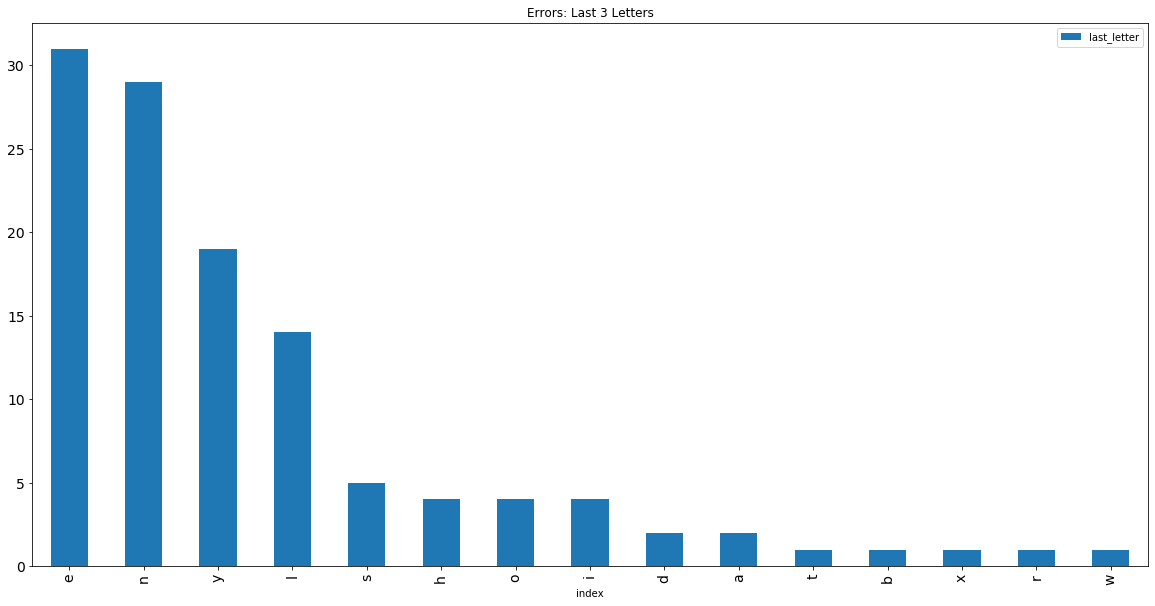

In [30]:
test_model(last_letter, corpus)

These are interesting results! Ending in `a` is the *only* letter in the top ten that predicts female names instead of male names. 

### Training on the last 3 letters of the name

Next, we try the last 3 letters. 

In [31]:
def test_model(feature_func, corpus):
    feature_func = feature_func #use feature function given as arg
    corpus = corpus
    
    # Run the feature_ext function to create the necessary labeled feature sets
    train_set, devtest_set, test_set = feature_ext(feature_func, corpus)
    
    # Train the naiveBayes classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set)

    # Test the accuracy of the classifier on the dev data--this is so we can evaluate errors and make tweaks
    a = round(nltk.classify.accuracy(classifier, devtest_set), 4)*100
    accuracy = f'{a:.2f}'
    print("\n")
    print("Model is %s percent accurate" % accuracy)
    print("\n")
    
    # examine classifier to determine which last letter is most effective for predicting gender
    print(classifier.show_most_informative_features(10))
    
    #find errors    
    def find_errors(dev_names, feature_func):   
        errors = {'name' : [], 'label' : [], 'guess' : [], 'features': [] }       
        for (name, label) in dev_names:
            guess = classifier.classify(feature_func(name))
            features = feature_func(name)
            if guess != label:
                errors['name'].append(name)
                errors['label'].append(label)
                errors['guess'].append(guess)
                errors['features'].append(features)
        
        errors = pd.DataFrame(errors)
        
        #create dataframe for bar plot
        hister = pd.DataFrame(errors[['features','guess']])
        hister = pd.DataFrame(hister['features'].tolist(), index=hister.index)

        hister2 = pd.DataFrame(hister['last3letters'].value_counts())
        hister2 = hister2.sort_values('last3letters',ascending=False)
        
        hister2.reset_index(level=0, inplace=True)
        
        #plot bar plot of errors caused by last letter
        hister2.plot('index','last3letters', kind='bar',figsize=(20,10), fontsize=14,title="Errors: Last 3 Letters")
        
        #prints sample 
        print("\nErrors")
        print(errors.sample(20))
    
    errors = find_errors(dev_names, feature_func)
    
    return classifier

Reslicer returns 3 sliced, remixed set of corpora:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Lindsy', 'female'), ('Maurise', 'male'), ('Joelle', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Aylmer', 'male'), ('Lynn', 'male'), ('Arlyne', 'female')] , Length:  500
Training Corpus Sample:  [('Angeline', 'female'), ('Kata', 'female'), ('Ira', 'female')] , Length:  6944


Model is 73.60 percent accurate


Most Informative Features
            last3letters = 'ana'          female : male   =     24.0 : 1.0
            last3letters = 'tta'          female : male   =     23.6 : 1.0
            last3letters = 'ard'            male : female =     20.0 : 1.0
            last3letters = 'nne'          female : male   =     18.3 : 1.0
            last3letters = 'vin'            male : female = 

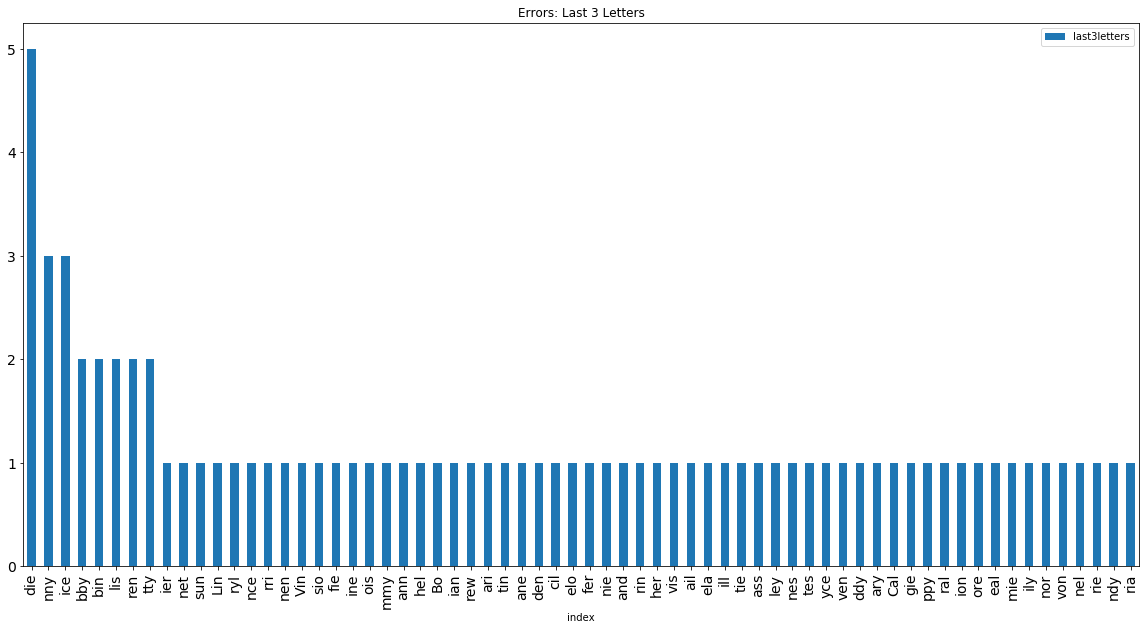

In [32]:
def one_feature(word):
    return {"last3letters": word[-3:]}  # feature set

#note, we are automatically re-slicing the training/dev-test slices
two_features_classifier = test_model(one_feature, corpus) 

### Training on the last 3 letters and the last letter

Next we try a combination of the last three letters as well as the last letter.

In [64]:
def two_features(word):
    return {"last_letter": word[-1], "last3letters": word[-3:]}  # feature set

#note, we are automatically re-slicing the training/dev-test slices
two_features_classifier = test_model(two_features, corpus) 

Reslicer returns 3 sliced, remixed set of corpuses:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Linzy', 'female'), ('Ruthi', 'female'), ('Jenda', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Sebastiano', 'male'), ('Celesta', 'female'), ('Ursa', 'female')] , Length:  500
Training Corpus Sample:  [('Alisa', 'female'), ('Rebe', 'female'), ('Margarette', 'female')] , Length:  6944


Model is 82.80 percent accurate


Most Informative Features
             last_letter = 'a'            female : male   =     36.6 : 1.0
            last3letters = 'nne'          female : male   =     31.3 : 1.0
             last_letter = 'k'              male : female =     30.3 : 1.0
            last3letters = 'ita'          female : male   =     24.4 : 1.0
            last3letters = 'tta'          female :

Adding the last three letters increased our accuracy by about 5 percentage points! Let's see if we can learn anything from the remaining errors to improve our model further.

# Maybe can cut this section -- or use for more error analysis?

I think besides data viz, the main thing we are missing here is error analysis leading to new feature extractions, e.g. because it missed  "Tracy" we will try...

An additional analysis we could do would be to extract names like "Tracy", "Laurie", "Leslie" that appear in *both* the male and female lists--there aren't really being coded "incorrectly" but they will count as errors.

   ### Analysis of name parts
   
Next, let's take a look at whether the presence or absence of any letters or consecutive groups of letters can tell us anything about the names by doing an analysis.

First, we create a function that returns all the combinations consecutive letters in a name, except the name itself. So, for example, in the name, "Noah", it returns the list:
```['N', 'No', 'Noa', 'o', 'oa', 'oah', 'a', 'ah', 'h']```

In [99]:
import numpy as np
def name_parts(name):
    i = 0
    letters = ''
    parts = []
    ans = ''
    for letter in name:
        next_part = name[i:]
        for letter in next_part:
            letters += letter
            parts.append(letters)
            i+=0
        letters=''
        i += 1
    return np.asarray(parts)
print(name_parts("Noah"))

['N' 'No' 'Noa' 'Noah' 'o' 'oa' 'oah' 'a' 'ah' 'h']


In [110]:
def parts_set(labeled_names):
    parts_set = []
    for name, label in labeled_names:
        features_list = name_parts(name)
        #print(features_list)
        parts_list = [(item, label) for item in features_list]
        #print(parts_list)
        parts_set += parts_list
        #print(parts_set)
    return parts_set

## Add data viz here?

In [111]:
train_names, dev_names, test_names = reslicer(corpus)
train_set2 = pd.DataFrame(parts_set(train_names))
dev_set2 = pd.DataFrame(parts_set(dev_names))

Reslicer returns 3 sliced, remixed set of corpuses:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Linzy', 'female'), ('Ruthi', 'female'), ('Jenda', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Ely', 'male'), ('Evy', 'female'), ('Carie', 'female')] , Length:  500
Training Corpus Sample:  [('Kirby', 'female'), ('Mace', 'male'), ('Karalynn', 'female')] , Length:  6944


In [112]:
dev_set2

,0,1
0,E,male
1,El,male
2,Ely,male
3,l,male
4,ly,male
5,y,male
6,E,female
7,Ev,female
8,Evy,female
9,v,female


In [106]:
# Train the naiveBayes classifier
classifier2 = nltk.NaiveBayesClassifier.train(train_set2)

TypeError: cannot unpack non-iterable int object

In [ ]:
a = round(nltk.classify.accuracy(classifier2, dev_set2), 4)*100
accuracy = f'{a:.2f}'
print("\n")
print("Model is %s percent accurate" % accuracy)
print("\n")

# examine classifier to determine which feature is most effective for predicting the name's gender
print(classifier2.show_most_informative_features(30))

This actually made it worse! Maybe we can combine some of these most important features with our previous model to close the gap even further.

In [48]:
#features with a greater than 15:1 predictive value
high_val_features = ['nna', 'tte', 'rv', 'hu', 'anna', 'bel', 'etta', 'ton', 'iu', 'son', 'Ros', 'ita', 'ina']

def combo_features(name):
    feature_set = {"last_letter": name[-1], "last3letters": name[-3:], 'high_val_features': ''}
    parts = name_parts(name)
    for feature in high_val_features:
        if feature in parts:
                feature_set.update({'high_val_features' : feature})
                break
    return feature_set

print(combo_features("BO"))
print(combo_features("Henrietta"))
print(combo_features("Rosita"))

{'last_letter': 'O', 'last3letters': 'BO', 'high_val_features': ''}
{'last_letter': 'a', 'last3letters': 'tta', 'high_val_features': 'etta'}
{'last_letter': 'a', 'last3letters': 'ita', 'high_val_features': 'Ros'}


In [49]:
#test model using new feature extractor
combo_classifier = test_model(combo_features, corpus)

Reslicer returns 3 sliced, remixed set of corpuses:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Test Corpus Sample:  [('Linzy', 'female'), ('Ruthi', 'female'), ('Jenda', 'female')] , Length:  500
Dev-Test Corpus Sample:  [('Shandee', 'female'), ('Keith', 'male'), ('Darline', 'female')] , Length:  500
Training Corpus Sample:  [('Charity', 'female'), ('Patrick', 'male'), ('Stacia', 'female')] , Length:  6944


Model is 79.80 percent accurate


Most Informative Features
             last_letter = 'k'              male : female =     43.0 : 1.0
             last_letter = 'a'            female : male   =     35.4 : 1.0
       high_val_features = 'tte'          female : male   =     34.1 : 1.0
            last3letters = 'nne'          female : male   =     30.9 : 1.0
       high_val_features = 'ton'            male : fe

This last bit didn't help much. Still, it's roughly as good as the two_features, so let's go ahead and test both and the on the test set.

### THIS PART IS NOT WORKING--NEED TO TEST THE MODELS ON THE TEST SET### 
train_set, dev_set, test_set = reslicer(corpus)

def final_test(classifier, test_set):
    # Test the accuracy of the classifier on the dev data--this is so we can evaluate errors and make tweaks
    a = round(nltk.classify.accuracy(classifier, test_set), 4)*100
    accuracy = f'{a:.2f}'
    print("\n")
    print("Model is %s percent accurate" % accuracy)
    print("\n")
    

final_test(two_features_classifier, test_set)
final_test(combo_classifier, test_set)

## Conclusion

In conclusion, the final test does not produce identical results when run on the test set (or even re-run on the development set). This should not be surprising because the model is making a prediction based on patterns that are not necessarily hard and fast rules. 

In addition, the corpus includes unisex names.

An interesting project for further study would be to add weights to the names based on the number of people who have each name so that more common names more heavily tilt the model. While this might not produce a more accurate result looking at a list of names, it should be more accurate when dealing with new, real-world data.

## `sklearn`  

From the site: https://blog.ayoungprogrammer.com/2016/04/determining-gender-of-name-with-80.html/    

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

Create the names corpus with gender assignment; each name is converted to lowercase.

In [ ]:
labeled_names = ([(name.lower(), "M") for name in names.words("male.txt")] +
                 [(name.lower(), "F") for name in names.words("female.txt")])

my_data = np.asarray(labeled_names) 

Using `sklearn`, we train a model on numbers associated with each letter in the name, where a=1, b=2, c=3, ... in this manner a model is created based on integer values.

In [232]:
def name_count(name):
    arr = np.zeros(65)
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
    return arr

name_map = np.vectorize(name_count, otypes=[np.ndarray])
Xlist = name_map(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.7219679633867276
0.7292143401983219
0.7315026697177727
0.7257818459191457
0.7265446224256293


In [186]:
def name_count2(name):
    arr = np.zeros(65+26)
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    return arr

name_map2 = np.vectorize(name_count2, otypes=[np.ndarray])
Xlist = name_map2(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.7829900839054157
0.7807017543859649
0.7864225781845919
0.7688787185354691
0.7936689549961862


In [193]:
def name_count3(name):
    arr = np.zeros(1800)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in range(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
    return arr

name_map3 = np.vectorize(name_count3, otypes=[np.ndarray])
Xlist = name_map3(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.7963386727688787
0.7967200610221206
0.7894736842105263
0.7917620137299771
0.7921434019832189


In [194]:
def name_count4(name):
    arr = np.zeros(1800)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in range(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
    # Last character
    arr[-3] = ord(name[-1])-ord('a')+1
    # Second Last character
    arr[-2] = ord(name[-2])-ord('a')+1
    # Length of name
    arr[-1] = len(name)
    return arr

name_map4 = np.vectorize(name_count4, otypes=[np.ndarray])
Xlist = name_map4(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.8180778032036613
0.8188405797101449
0.8096872616323417
0.8032036613272311
0.8081617086193745


In [195]:
def name_count7(name):
    arr = np.zeros(1800)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in range(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
    # Last character
    arr[-3] = ord(name[-1])-ord('a')+1
    # Second Last character
    arr[-2] = ord(name[-2])-ord('a')+1
    # Length of name
    arr[-1] = len(name)
    return arr

name_map7 = np.vectorize(name_count7, otypes=[np.ndarray])
Xlist = name_map7(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=150, min_samples_split=20)
    clf.fit(Xtr, ytr)
    print(clf.feature_importances_.argsort()[-10:][::-1])
    print(np.mean(clf.predict(Xte) == yte))

[1797   26 1798   40   30   34    0   43   29    8]
0.8081617086193745
[1797   26 1798   40   30    0   34   43   22   29]
0.8119755911517925
[1797   26 1798   40    0   30   34   43 1799    8]
0.8005339435545386
[1797   26 1798   40   30    0   34   43   29 1799]
0.8012967200610221
[1797   26 1798   40    0   30   34   43   29 1799]
0.8154080854309688


The following code trains a model based on the last letter of the name.

In [224]:
def name_count8(name):
    arr = np.zeros(1)
    arr[0] = ord(name[-1])-ord('a')+1
    return arr

name_map8 = np.vectorize(name_count8, otypes=[np.ndarray])
Xlist = name_map8(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=150, min_samples_split=20)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.761632341723875
0.7715484363081617
0.7528604118993135
0.7570556826849733
0.7589626239511823


The following code trains a model based on the last three letters of the name.

In [228]:
def name_count9(name):
    arr = np.zeros(3)
    arr[0] = ord(name[-1])-ord('a')+1
    arr[1] = ord(name[-2])-ord('a')+1
    for ind, x in enumerate(name):
        if len(name)>=3:
            arr[2] = ord(name[-3])-ord('a')+1
    
    return arr

name_map9 = np.vectorize(name_count9, otypes=[np.ndarray])
Xlist = name_map9(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=150, min_samples_split=20)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))

0.7890922959572845
0.7913806254767353
0.8012967200610221
0.7940503432494279
0.8032036613272311


In [221]:
def name_count10(name):
    arr = np.zeros(3)
    arr[0] = ord(name[-1])-ord('a')+1
    arr[1] = ord(name[-2])-ord('a')+1
    # Order of a's
    for ind, x in enumerate(name):
        if x == 'a':
            arr[2] += ind+1
    
    return arr

name_map10 = np.vectorize(name_count10, otypes=[np.ndarray])
Xlist = name_map10(np.asarray(list(zip(*my_data))[0],dtype=str))
X = np.array(Xlist.tolist())
y = [x[1] for x in my_data]

for x in range(5):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=150, min_samples_split=20)
    clf.fit(Xtr, ytr)
    print(np.mean(clf.predict(Xte) == yte))


0.7784134248665141
0.7738367658276125
0.7734553775743707
0.7837528604118993
0.7738367658276125


In [207]:
idx = np.random.choice(np.arange(len(Xlist)), 10, replace=False)
Xname = [x[0] for x in my_data]
xs = [Xname[x] for x in idx]
ys = [y[x] for x in idx]
pred = clf.predict(X[idx])

for a,b, p in zip(xs,ys, pred):
    print(a,b, p)

reid M M
galina F F
bishop M M
channa F F
uta F F
tracy M M
gillian F M
cindi F F
eustacia F F
raleigh M M


In [231]:
for x in range(5): 
    print(X[x])
    print(Xname[x])

[18.  9. 13.]
aamir
[14. 15. 18.]
aaron
[25.  5.  2.]
abbey
[5. 9. 2.]
abbie
[20. 15.  2.]
abbot
